In [11]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set(style="whitegrid", rc={"figure.figsize": (10,5)})
pd.options.display.float_format = lambda x: f"{x:.4f}"

In [12]:

FILE = "online_retail_ii.csv" 

#  загрузка с запасом по кодировке и разделителю
def read_csv_smart(path_or_buf):
    encodings = ("utf-8", "ISO-8859-1", "latin1")
    seps = (None, ",", ";", "\t")  
    last_err = None
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path_or_buf, encoding=enc, sep=sep, engine="python", on_bad_lines="skip")
                # если слепилось в 1 колонку, продолжаем искать
                if df.shape[1] == 1 and any(ch in df.columns[0] for ch in [";", "\t", ","]):
                    continue
                return df
            except Exception as e:
                last_err = e
    raise RuntimeError(f"Не удалось прочитать CSV. Последняя ошибка: {last_err}")

#  нормализация названий
def canon(s): 
    return re.sub(r"[^a-z0-9]+", " ", str(s).lower()).strip()

ALIASES = {
    # даты и айди
    "invoicedate":"InvoiceDate", "invoice date":"InvoiceDate", "date":"InvoiceDate",
    "invoiceno":"InvoiceNo", "invoice no":"InvoiceNo", "invoice":"InvoiceNo",
    "customerid":"CustomerID", "customer id":"CustomerID",
    # числа и деньги
    "quantity":"Quantity",
    "unitprice":"UnitPrice", "unit price":"UnitPrice", "price":"UnitPrice",
    # атрибуты
    "country":"Country", "city":"City", "state":"State",
    "customer name":"CustomerName", "customername":"CustomerName",
    "stockcode":"StockCode",
    # метрики
    "sales":"Sales", "revenue":"Sales",  # если есть прямые продажи
    "discount":"Discount", "profit":"Profit"
}

def normalize_columns(df):
    mapping = {}
    for c in df.columns:
        cc = canon(c)
        if cc in ALIASES:
            mapping[c] = ALIASES[cc]
    return df.rename(columns=mapping)

# читаем и нормализуем
raw = read_csv_smart(FILE)
df = normalize_columns(raw).copy()
display(df.head())
print("Колонки:", list(df.columns))
print("Строк:", len(df))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


Колонки: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Строк: 1067371


In [13]:
# дата
if "InvoiceDate" not in df.columns:
    raise ValueError("Не нашёл колонку с датой (InvoiceDate / Invoice Date / Date). Переименуй нужный столбец.")

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"]).copy()

# числа
for c in ["Quantity", "UnitPrice", "Sales", "Discount"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# если явной Sales нет — считаем Total = Quantity*UnitPrice
if "Sales" not in df.columns:
    if not {"Quantity","UnitPrice"}.issubset(df.columns):
        raise ValueError("Нет Sales и не найдено Quantity/UnitPrice для рассчёта.")
    df["Sales"] = df["Quantity"] * df["UnitPrice"]

# Возвраты (классика Online Retail: отрицательное количество или кредитные инвойсы)
df["is_return"] = False
if "Quantity" in df.columns:
    df.loc[df["Quantity"] < 0, "is_return"] = True
if "InvoiceNo" in df.columns:
    df.loc[df["InvoiceNo"].astype(str).str.startswith("C", na=False), "is_return"] = True

# витрина sales — только продажи (без возвратов), только валидные суммы
sales = df[~df["is_return"]].copy()
sales = sales[sales["Sales"].notna() & (sales["Sales"] != 0)]

# пользовательский идентификатор
if "CustomerID" in sales.columns and sales["CustomerID"].notna().any():
    sales = sales.dropna(subset=["CustomerID"]).copy()
    # СustomerID часто float — приводим к int безопасно
    sales["user_id"] = sales["CustomerID"].astype(str).str.replace(".0","", regex=False)
else:
    # суррогат по (Country, CustomerName) — если нет CustomerID
    base_cols = [c for c in ["Country","CustomerName"] if c in sales.columns]
    if base_cols:
        sales["user_id"] = sales[base_cols].astype(str).agg("|".join, axis=1)
    else:
        # минимум по стране и порядковому номеру
        key = "Country" if "Country" in sales.columns else None
        if key:
            sales["user_id"] = sales.groupby(key).cumcount().astype(str)
        else:
            sales["user_id"] = sales.groupby(sales.index // 1).cumcount().astype(str)

# месяц заказа
sales["order_month"] = sales["InvoiceDate"].dt.to_period("M").dt.to_timestamp()

print("Продаж (после фильтров):", len(sales), "| пользователей:", sales["user_id"].nunique())
display(sales[["InvoiceDate","user_id","Sales"]].head())

Продаж (после фильтров): 805549 | пользователей: 5878


,InvoiceDate,user_id,Sales
0,2009-12-01 07:45:00,13085,83.4000
1,2009-12-01 07:45:00,13085,81.0000
2,2009-12-01 07:45:00,13085,81.0000
3,2009-12-01 07:45:00,13085,100.8000
4,2009-12-01 07:45:00,13085,30.0000


In [14]:
snapshot_date = sales["InvoiceDate"].max() + pd.Timedelta(days=1)

# Frequency: лучше по инвойсам, если есть; иначе по дням
if "InvoiceNo" in sales.columns:
    freq_src = sales.groupby(["user_id","InvoiceNo"])["InvoiceDate"].max().reset_index()
    freq = freq_src.groupby("user_id")["InvoiceNo"].nunique()
else:
    freq_src = sales.assign(day=sales["InvoiceDate"].dt.floor("D"))
    freq = freq_src.groupby("user_id")["day"].nunique()

rfm = pd.DataFrame({
    "user_id": sales["user_id"].unique()
}).merge(
    sales.groupby("user_id")["InvoiceDate"].max().rename("last_date"),
    on="user_id", how="left"
).merge(
    sales.groupby("user_id")["Sales"].sum().rename("monetary"),
    on="user_id", how="left"
)

rfm["recency_days"] = (snapshot_date - rfm["last_date"]).dt.days
rfm["frequency"] = rfm["user_id"].map(freq)

# квантильный биннинг 
r_labels = [4,3,2,1]  # чем меньше recency — тем лучше
rfm["R"] = pd.qcut(rfm["recency_days"], 4, labels=r_labels)
rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"),  4, labels=[1,2,3,4])
rfm[["R","F","M"]] = rfm[["R","F","M"]].astype(int)
rfm["RFM_score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

seg = rfm.groupby("RFM_score").agg(
    users=("user_id","nunique"),
    avg_recency=("recency_days","mean"),
    avg_freq=("frequency","mean"),
    avg_mon=("monetary","mean")
).sort_values("users", ascending=False).reset_index()

print("Топ RFM-сегментов:")
display(seg.head(10))

Топ RFM-сегментов:


,RFM_score,users,avg_recency,avg_freq,avg_mon
0,444,666,10.3003,24.3153,14481.2022
1,111,627,548.9394,1.0000,178.8439
2,344,343,51.3032,13.4023,6389.6844
3,211,284,246.6021,1.0000,182.6525
4,333,251,54.7689,4.5179,1452.5298
5,433,224,13.0402,4.6607,1385.8583
6,233,222,222.8063,4.7477,1431.9520
7,222,219,237.3379,2.2922,585.8699
8,122,212,478.4340,2.2594,580.1507
9,112,181,520.8729,1.0000,485.3531


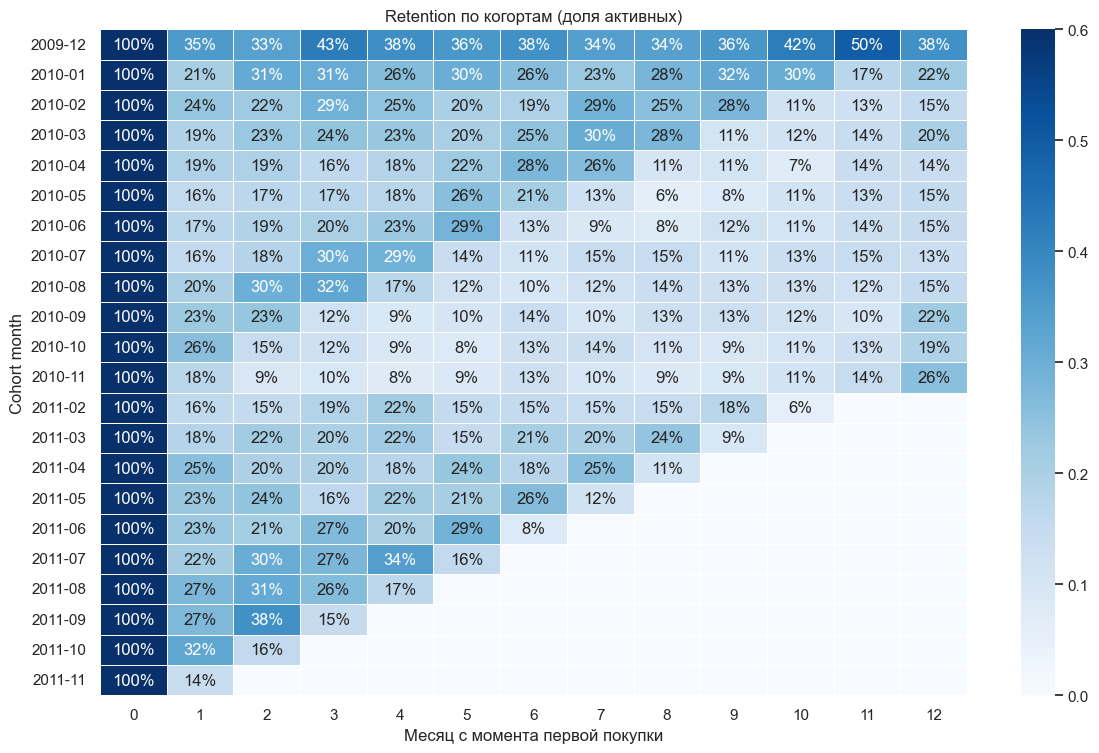

,cohort_size
2009-12-01,955
2010-01-01,383
2010-02-01,374
2010-03-01,443
2010-04-01,294


In [15]:
def build_retention(sales_df, max_months=12, min_cohort_size=50):
    first = sales_df.groupby("user_id")["order_month"].min().rename("cohort_month")
    coh = sales_df.merge(first, on="user_id", how="left")
    coh["cohort_index"] = (
        (coh["order_month"].dt.year - coh["cohort_month"].dt.year) * 12 +
        (coh["order_month"].dt.month - coh["cohort_month"].dt.month)
    )

    users = coh.groupby(["cohort_month","cohort_index"])["user_id"].nunique().reset_index(name="n_users")
    sizes = users[users["cohort_index"]==0][["cohort_month","n_users"]].rename(columns={"n_users":"cohort_size"})

    ret = users.merge(sizes, on="cohort_month", how="left")
    ret["retention"] = ret["n_users"] / ret["cohort_size"]

    valid = sizes.query("cohort_size >= @min_cohort_size")["cohort_month"]
    ret = ret[(ret["cohort_index"] <= max_months) & (ret["cohort_month"].isin(valid))]

    pivot = ret.pivot(index="cohort_month", columns="cohort_index", values="retention").sort_index().fillna(0)
    pivot.index = pd.to_datetime(pivot.index).strftime("%Y-%m")
    return pivot, sizes.set_index("cohort_month").loc[valid].rename_axis(index=None)

def plot_retention(pivot: pd.DataFrame, vmax=None):
    # аннотации без applymap: показываем только >0
    labels = pivot.mask(pivot <= 0)
    labels = (labels * 100).round().astype("Int64").astype(str) + "%"
    labels = labels.replace("<NA>%", "")

    h = max(6, 0.35 * len(pivot))
    w = max(8, 0.7 * pivot.shape[1] + 3)

    plt.figure(figsize=(w, h))
    sns.heatmap(
        pivot, annot=labels, fmt="", cmap="Blues",
        vmin=0, vmax=vmax or min(0.6, max(pivot.max().max(), 0.3)),
        linewidths=0.5
    )
    plt.title("Retention по когортам (доля активных)")
    plt.xlabel("Месяц с момента первой покупки")
    plt.ylabel("Cohort month")
    plt.tight_layout()
    plt.show()

pivot_ret, cohort_sizes = build_retention(sales, max_months=12, min_cohort_size=100)
plot_retention(pivot_ret)
display(cohort_sizes.head())

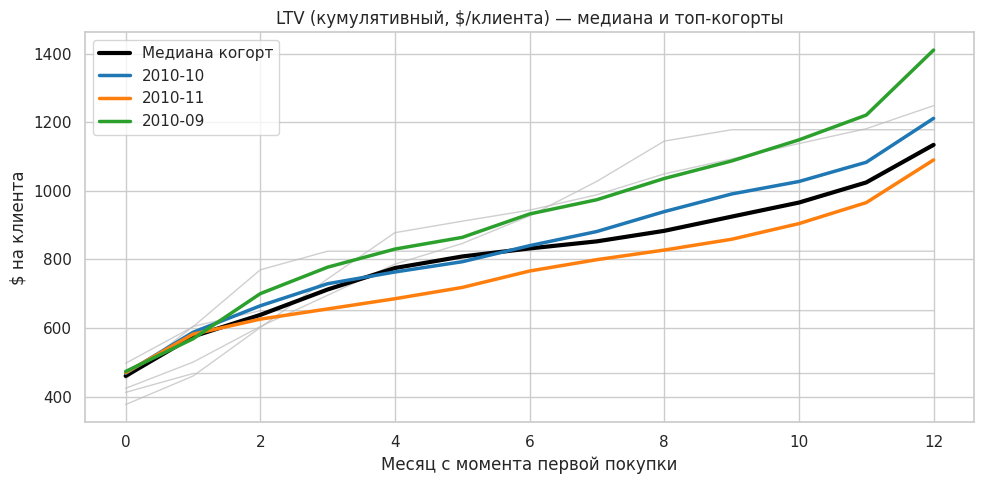

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2010-08,376.8941,459.8502,601.4846,743.6748,878.2029,911.7374,943.8678,988.8556,1049.7410,1093.2546,1138.1586,1181.4623,1248.7354
2010-09,473.3356,568.5879,700.3672,777.5395,830.3558,864.5149,932.7743,974.4077,1036.2939,1087.3230,1148.8447,1221.2441,1410.8930
2010-10,468.0875,587.5341,664.9119,729.2421,763.5488,793.4611,840.3171,881.6880,939.6424,991.0162,1027.4659,1083.6103,1211.7045
2010-11,469.8830,582.1019,625.9629,655.6950,685.5240,718.4586,766.3715,799.4690,827.5158,858.9425,904.6251,965.8939,1090.3623
2011-03,424.1815,500.4465,604.3998,695.6096,786.6023,846.7035,927.1021,1028.0834,1145.3280,1178.4846,1178.4846,1178.4846,1178.4846


In [17]:
import matplotlib
matplotlib.rcParams["font.family"] = "DejaVu Sans"  
matplotlib.rcParams["axes.unicode_minus"] = False    # чтобы минусы в осях не глючили
def build_ltv(sales_df, revenue_col="Sales", max_months=12, min_cohort_size=100, last_n_cohorts=8):
    first = sales_df.groupby("user_id")["order_month"].min().rename("cohort_month")
    coh = sales_df.merge(first, on="user_id", how="left")
    coh["cohort_index"] = (
        (coh["order_month"].dt.year - coh["cohort_month"].dt.year) * 12 +
        (coh["order_month"].dt.month - coh["cohort_month"].dt.month)
    )

    users = coh.groupby(["cohort_month","cohort_index"])["user_id"].nunique().reset_index(name="n_users")
    sizes = users[users["cohort_index"]==0][["cohort_month","n_users"]].rename(columns={"n_users":"cohort_size"})

    rev = coh.groupby(["cohort_month","cohort_index"])[revenue_col].sum().reset_index(name="revenue")
    ltv = rev.merge(sizes, on="cohort_month", how="left")
    ltv = ltv[ltv["cohort_size"] > 0].copy()
    ltv["ltv"] = ltv["revenue"] / ltv["cohort_size"]

    valid = sizes.query("cohort_size >= @min_cohort_size")["cohort_month"]
    ltv = ltv[(ltv["cohort_month"].isin(valid)) & (ltv["cohort_index"] <= max_months)]

    pivot = ltv.pivot(index="cohort_month", columns="cohort_index", values="ltv").sort_index().fillna(0)
    pivot = pivot.cumsum(axis=1)

    # последние N когорт
    if last_n_cohorts is not None and len(pivot) > last_n_cohorts:
        pivot = pivot.tail(last_n_cohorts)
        sizes = sizes.set_index("cohort_month").loc[pivot.index].reset_index()

    pivot.index = pd.to_datetime(pivot.index).strftime("%Y-%m")
    return pivot, sizes

def plot_ltv_lines(pivot: pd.DataFrame, sizes: pd.DataFrame, top_k=3):
    x = pivot.columns.values
    # фоновые линии серым
    for idx, row in pivot.iterrows():
        plt.plot(x, row.values, color="#BBBBBB", linewidth=1, alpha=0.7)

    # медиана по всем выбранным когортам
    med = pivot.median(axis=0)
    plt.plot(x, med.values, color="black", linewidth=3, label="Медиана когорт")

    # топ-k по размеру
    sizes = sizes.copy()
    sizes["cohort_str"] = pd.to_datetime(sizes["cohort_month"]).dt.strftime("%Y-%m")
    top = sizes.sort_values("cohort_size", ascending=False).head(top_k)["cohort_str"].tolist()
    palette = sns.color_palette("tab10", n_colors=top_k)
    for i, name in enumerate(top):
        if name in pivot.index:
            plt.plot(x, pivot.loc[name].values, linewidth=2.5, color=palette[i], label=name)

    plt.title("LTV (кумулятивный, $/клиента) — медиана и топ‑когорты")
    plt.xlabel("Месяц с момента первой покупки")
    plt.ylabel("$ на клиента")
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

#  прижимаем хвосты (winsorize) — одиночные огромные чеки не ломают шкалу
p995 = sales["Sales"].quantile(0.995)
sales_w = sales.assign(Sales = sales["Sales"].clip(upper=p995))

# строим LTV по последним 8 крупным когортам, первые 12 месяцев
ltv_pivot, ltv_sizes = build_ltv(
    sales_w, revenue_col="Sales", max_months=12, min_cohort_size=150, last_n_cohorts=8
)

# ну и рисуем
plot_ltv_lines(ltv_pivot, ltv_sizes, top_k=3)

display(ltv_pivot.head())

In [18]:
# сохраняем витрины и сводки (по желанию)
rfm.to_csv("rfm_table.csv", index=False)
seg.to_csv("rfm_segments_summary.csv", index=False)
pivot_ret.to_csv("retention_pivot.csv")
ltv_pivot.to_csv("ltv_pivot.csv")

print("Сохранено: rfm_table.csv, rfm_segments_summary.csv, retention_pivot.csv, ltv_pivot.csv")

Сохранено: rfm_table.csv, rfm_segments_summary.csv, retention_pivot.csv, ltv_pivot.csv
